# Graph firstorder accuracy vs. blast
For a set of query sequences x and true labels y, compute the accuracy based on assigning each query the label of the nearest sequence in the test set according to blastn evalues, compare this with our performance and the reported values in Nielsen.

In [1]:
import numpy as np
import pandas as pd
import sys
import random
import os
random.seed(42)
np.random.seed(42)
sys.path.append("../")
from common.plot_style_utils import set_pub_plot_context, save_for_pub
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
result_name = '../../data/blast/blast_firstorder_test.csv'
predictions_name = 'firstorder_blast_test_predictions'
x = pd.read_pickle("../../data/tts/test_x_no_nan.pkl")
y = pd.read_pickle("../../data/tts/y_test_ord.pkl")

database="firstorder"

In [3]:
if database == "firstorder":
    train_y = pd.read_pickle("../../data/tts/y_train_ord.pkl")
elif database == "countries":
    train_y = pd.read_pickle("../../data/tts/y_train_country.pkl")
else:
    raise ValueError("Database unknown")

# This cell requires large memory to open the Blast query results- skip below if 32G mem unavailable. Will appear interrupted.

In [4]:
# 
predictions = []
k = 10
headers = ['query_id', 'subject_id', 'identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score']
result = pd.read_csv(result_name, index_col=1, sep='\t', names=headers).reset_index()
print(result.head())
# for every element in query
for i in range(len(x)):
    queryi_result = result[result["query_id"] == i]
    # sort all the hits by evalue, drop duplicate hits (keeping the lowest evalue)
    sorted_hits = np.asarray(
        queryi_result.sort_values("evalue").loc[:,"subject_id"].drop_duplicates().values, 
        dtype=int
    )
    # Look up the train set labels for each sequence hit, drop the duplicate labs
    # (keeping the evalue ordering) and take the first k lab predictions
    predictions.append(pd.Series(train_y[sorted_hits]).drop_duplicates().values[:k])

/home/sandias42/miniconda3/envs/attrib/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


   subject_id  query_id  identity  alignment length  mismatches  gap opens  \
0           0         0     92.28               622          36         12   
1       21017         0     92.13               597          35         12   
2           9         0     92.13               597          35         12   
3       34681         0     92.07               593          35         12   
4        1156         0     85.31               572          75          9   

   q. start  q. end  s. start  s. end         evalue  bit score  
0       581    1198      3816    3203   0.000000e+00      872.0  
1       606    1198      3343    2755   0.000000e+00      832.0  
2       606    1198      3401    2813   0.000000e+00      832.0  
3       610    1198      3985    3401   0.000000e+00      824.0  
4       609    1177      3330    2765  1.000000e-164      582.0  


In [5]:
%xdel result

In [6]:
predictions[:10]

[array([ 142.,  192., 1218., 1034., 1313.,  481.,  735.]),
 array([ 142.,   88., 1313.,  390.,   89., 1177., 1035., 1185., 1218.,
         150.]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([1136.,  558.,   45., 1313.,  505.,  951.,  313.,  676., 1309.,
         220.]),
 array([1136.,  161.]),
 array([1202., 1313.]),
 array([ 172.,  410.,  667.,  439.,  234.,  380., 1313.,  945.,  374.,
         382.]),
 array([], dtype=float64),
 array([1136., 1272., 1313.,  111.,  275.,  572.,  532., 1202.,   24.,
         625.])]

In [7]:
y[:10]

array([ 142.,  142.,  142.,  142., 1136., 1136., 1136., 1136., 1136.,
       1136.])

In [8]:
np.save(predictions_name,np.array(predictions, dtype=object))

In [9]:
# Top 1 accuracy = .6633
top1_prediction = np.array([a[0] if len(a) != 0 else 9999999 for a in predictions])
correct = (top1_prediction == y)
blast_accuracy1 = np.mean(correct)
blast_accuracy1

0.663377675975685

In [10]:
# topk accuracy (see k set above)
# with k=10 top10= .74848
correct = [y[i] in predictions[i] if len(predictions[i]) != 0 else y[i] == 9999999 for i in range(len(y))]
blast_accuracy10 = np.mean(correct)
blast_accuracy10

0.7484803101048366

# Skip here if on a low-ram machine

In [4]:

class_labels=np.arange(1314)
def best_guess(true, 
               train_y=train_y, 
               class_labels=class_labels,
                k=1
              ):
    """ 
    Guesses most abundant class in the training set.
    """
    guess = np.argsort(
        np.bincount(np.asarray(train_y, dtype=int))
    )[-k:]
    correct = np.isin(true,guess)
    accuracy = np.sum(correct) / len(true)
    return accuracy

In [5]:
np.max(np.bincount(np.array(y,int))) / len(y)

0.07541185798608052

In [6]:
guess1 = best_guess(y,k=1)
guess1

0.07541185798608052

In [7]:
guess10 = best_guess(y, k=10)
guess10

0.15152849969165713

In [8]:


labels = ["deteRNNt", "- Phenotype", "Blast",
          "CNN", "Baseline", "Uniform"]
# Using values from:
# TEST_accuracy_and_top10_accuracy_full.ipynb
top1 = [.700,.599, .663,.502,guess1, 1/len(np.unique(train_y))]
top10 = [.847,.803, .7484,.734, guess10, 10/len(np.unique(train_y))]



In [9]:
df = pd.DataFrame({'Method':labels*2, "Accuracy":top1 + top10, 
                   "Top k":["k=1"] * len(labels) + ["k=10"]*len(labels)})

In [10]:
import warnings
warnings.filterwarnings('once')

mkdir: cannot create directory ‘../../data/manuscript/figs/1/e_bar’: File exists


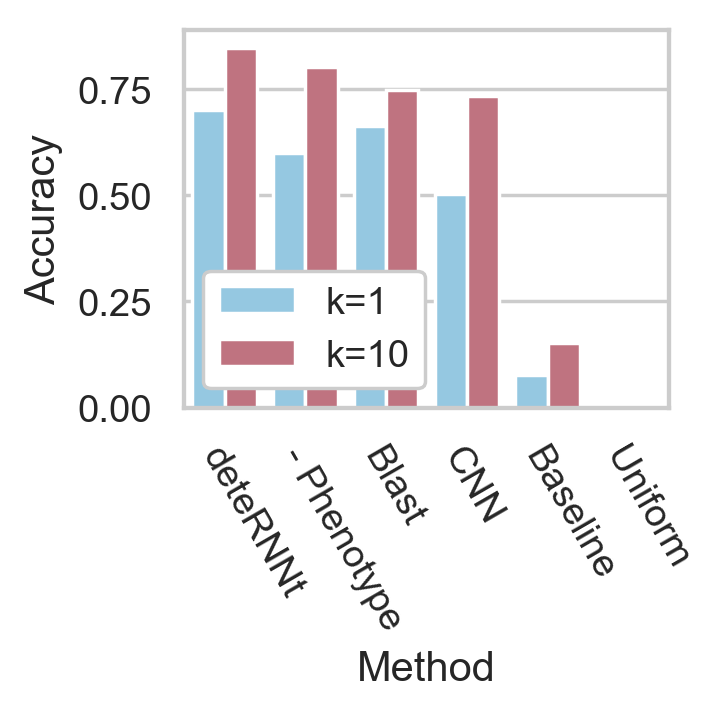

In [11]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(2.5,2.0), dpi=250)
ax1 = fig.add_subplot(111,
                    xlabel="Accuracy")
palette = sns.color_palette()

sns.barplot(y="Accuracy", x="Method", hue="Top k", data=df, alpha=1, ax=ax1, )
plt.xticks(rotation=-60, ha="left", rotation_mode="anchor")
plt.legend(loc='lower left', framealpha=1)
!mkdir ../../data/manuscript/figs/1/e_bar
save_for_pub(fig, path="../../data/manuscript/figs/1/e_bar/v3_reviewer", dpi=500)

In [12]:
labels = ["Yes", "No"]
top1 = [.700,.599]
top10 = [.847,.803]

In [13]:
df = pd.DataFrame({'Phenotype':labels*2, "Accuracy":top1 + top10, 
                   "Top k":["k=1"] * len(labels) + ["k=10"]*len(labels)})

mkdir: cannot create directory ‘../../data/manuscript/figs/1/f_bar’: File exists


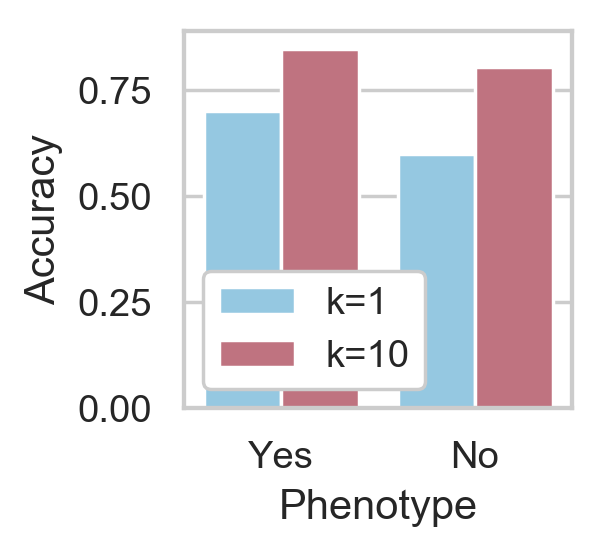

In [14]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(2,2), dpi=250)
ax1 = fig.add_subplot(111,
                    xlabel="Accuracy")
palette = sns.color_palette()

sns.barplot(y="Accuracy", x="Phenotype", hue="Top k", data=df, alpha=1, ax=ax1, )

plt.legend(loc='lower left', framealpha=1)
!mkdir ../../data/manuscript/figs/1/f_bar
save_for_pub(fig, path="../../data/manuscript/figs/1/f_bar/v0", dpi=500)